# Bird species image classification

In [1]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-cp37-none-any.whl size=16443 sha256=24abcec72f009b862636b9227dd43600c557a4a4f26b227f02ce467df6f049bb
  Stored in directory: /root/.cache/pip/wheels/84/27/aa/c46d23c4e8cc72d41283862b1437e0b3ad318417e8ed7d5921
Successfully built efficientnet-pytorch


In [2]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data.sampler import SubsetRandomSampler
import PIL
from pathlib import Path
from efficientnet_pytorch import EfficientNet
import time

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
cd "/content/drive/MyDrive/bird_species"

/content/drive/MyDrive/bird_species


В задаче классификации участвовали фотографии 20 классов (фотографии были собраны из google images по английским названиям.

In [6]:
BATCH_SIZE = 50
n_epochs = 10

## 1 Classification

### 1.1 Dataset & dataloader

Фотографии находятся в папках своего класса без разделения на тестовую и обучающую выборки.

In [7]:
img_path = './bird_dataset/bird_img' # путь до папки с датасетом

In [8]:
labels = sorted(os.listdir(img_path))
label_dict = {i:labels[i] for i in range(0, len(labels))}
num_classes = len(label_dict)

In [9]:
label_dict

{0: 'black_kite',
 1: 'chaffinch',
 2: 'common_magpie',
 3: 'common_raven',
 4: 'crested_tit',
 5: 'eurasian_jay',
 6: 'eurasian_pygmy-owl',
 7: 'eurasian_tree_sparrow',
 8: 'european_turtle-dove',
 9: 'great_spotted_woodpecker',
 10: 'hazel_grouse',
 11: 'northern_harrier',
 12: 'rock_pigeon',
 13: 'ruddy_shelduck',
 14: 'snow_goose',
 15: 'snowy_owl',
 16: 'waxwing',
 17: 'white_stork',
 18: 'white_wagtail',
 19: 'willow_grouse'}

In [10]:
class BirdDataset(Dataset):
    def __init__(self, img_folder, img_size):
      
        super().__init__()
        self.img_folder = img_folder
    
        transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Resize(img_size),
                                        transforms.RandomAutocontrast(p=0.3),
                                        transforms.GaussianBlur(1, sigma=(0.1, 0.2)),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                        ])
     
        self.dataset = datasets.ImageFolder(self.img_folder, transform=transform)

    def __len__(self):
        return len(self.dataset)
  
    def __getitem__(self, idx):  
        img_tensor = self.dataset[idx][0]
        object_label = self.dataset[idx][1]

        return {'image': img_tensor, 'label': object_label}

In [11]:
bird_set = BirdDataset(img_path,[256, 256])

In [12]:
len(bird_set)

5434

In [69]:
def show_img_n_lbl(data_set, is_labels_pred=False):

    f, axes = plt.subplots(2,5, figsize=(14, 6))
    for i in range(2):
        for p in range(5):
            idx = np.random.randint(0, len(data_set))
            img_tensor = data_set[idx]['image']
            label = data_set[idx]['label']
            image = np.moveaxis(img_tensor.numpy(), 0, 2)
            image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            im_lb = label_dict[label]
            if is_labels_pred:
                with torch.no_grad():
                    label_pred = model(torch.unsqueeze(img_tensor, dim=0).to(device)).cpu().numpy()[0].argmax()
                pred_im_lb = label_dict[label_pred]
                axes[i][p].text(127, -30, 
                                pred_im_lb, 
                                horizontalalignment='center', 
                                verticalalignment='top', 
                                color='darkred', fontsize=12)
         
            axes[i][p].axis('off')
            axes[i][p].imshow(image.clip(0, 1))
            axes[i][p].set_title(im_lb, pad=18, color='darkgreen', fontsize=12)


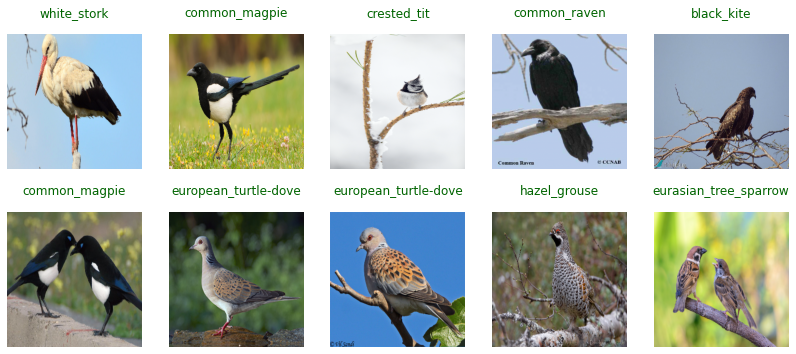

In [47]:

show_img_n_lbl(bird_set, is_labels_pred=False)

#### 1.1.1 Train & val split 

In [14]:
# train/val split 
train_size = int(0.8 * len(bird_set))
val_size = len(bird_set) - train_size
train_set, val_set = torch.utils.data.random_split(bird_set, 
                                                    [train_size, val_size], 
                                                    generator=torch.Generator().manual_seed(42))

In [15]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

## 1.2 Network architecture

В качестве модели использовалась предобученная [EfficientNet](https://arxiv.org/pdf/1905.11946.pdf)

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = EfficientNet.from_name('efficientnet-b0')
model.load_state_dict(torch.load('./efficientnet-b0-08094119.pth'))   # from https://www.kaggle.com/hmendonca/efficientnet-pytorch
in_features = model._fc.in_features
model._fc = nn.Linear(in_features, num_classes)
model = model.to(device)

In [17]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [18]:
def train_epoch(loader, optimizer):

    model.train()
    epoch_loss = 0.
    correct = 0
    total = 0

    for batch in loader:
        images, labels = batch['image'], batch['label']
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        predictions = model(images)
        correct += (labels == predictions.argmax(dim=1,)).sum()
        total += len(labels)

        loss = loss_function(predictions, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    print(f'Train: {epoch_loss / len(loader)} | acc: {correct / total}')
    return epoch_loss

  
def val_epoch(loader, optimizer):

    model.eval()
    epoch_loss = 0.
    correct = 0
    total = 0

    for batch in loader:
        images, labels = batch['image'], batch['label']
        images = images.to(device)
        labels = labels.to(device)

        predictions = model(images)
        
        correct += (labels == predictions.argmax(dim=1,)).sum()
        total += len(labels)

        with torch.no_grad():
            loss = loss_function(predictions, labels)
            
        epoch_loss += loss.item()
    print(f'Test: {epoch_loss / len(loader)} | acc: {correct / total}')
    return epoch_loss

In [19]:
start = time.time()
for epoch in range(n_epochs):

    print('Epoch {}/{}'.format(epoch + 1, n_epochs))
    train_loss = train_epoch(train_loader, optimizer)
    val_loss = val_epoch(val_loader, optimizer)
end = time.time()
print('Time: {}'.format(end - start))

Epoch 1/10
Train: 2.2148886740892784 | acc: 0.5942028760910034
Test: 0.7871620248664509 | acc: 0.8454461693763733
Epoch 2/10
Train: 0.5883022272723845 | acc: 0.9208649396896362
Test: 0.2350355644117702 | acc: 0.9558417201042175
Epoch 3/10
Train: 0.21173902249884333 | acc: 0.9650333523750305
Test: 0.1514341760088097 | acc: 0.9724010825157166
Epoch 4/10
Train: 0.10305874927461832 | acc: 0.9852771759033203
Test: 0.11539487828585235 | acc: 0.9751609563827515
Epoch 5/10
Train: 0.05667830459859179 | acc: 0.9940188527107239
Test: 0.09252854419702833 | acc: 0.9825206995010376
Epoch 6/10
Train: 0.04173415509619932 | acc: 0.9947089552879333
Test: 0.08563748154450547 | acc: 0.9806807637214661
Epoch 7/10
Train: 0.029141274334370405 | acc: 0.998159646987915
Test: 0.09010047998956659 | acc: 0.9779208302497864
Epoch 8/10
Train: 0.02136096826636757 | acc: 0.9972394704818726
Test: 0.0891744603021917 | acc: 0.9779208302497864
Epoch 9/10
Train: 0.015466300974032659 | acc: 0.9986197352409363
Test: 0.08273

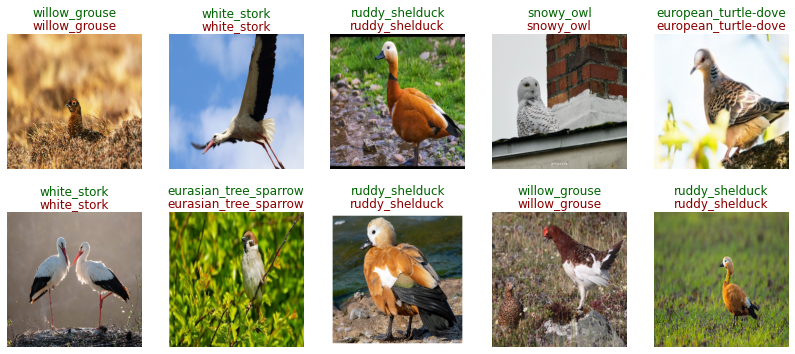

In [70]:
show_img_n_lbl(val_set, is_labels_pred=True)